<a href="https://colab.research.google.com/github/sarashahin/ML_Research/blob/main/Fork_of_Ensemble_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lung-tumour:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4503150%2F7711710%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240805%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240805T140325Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D562330e823fc516ad73486b1723fcb941079691b266d0616773ad3acb5cb4177e888f0d408119c799087015a363e9f5f7682aedcc9cacd505880f420bc6f3ad029d75745790e537a228293192b72fb647c37a976468b39e3901c2022b107c8a2f9cbc6f80e79811e114377c78e66c9582ae18d2fa3ccd7d915290d4b5bc595d8cef36b736c6a77d26927beb950a4755a2e30055207fe3b6308314b22026ff0f40b2e40283a3c717194f7339c7cb7bff78e691f29ce5833d9b03531f104615cf0872e564029bd8f561f62abd5879f7688f4d3db63ff3233543d5df8515266c1a38bb9c1fe18a23f56a9c0605ea434e089f5eb13bd93eeb1e0b8ba6be8f7d88f0d,ensemble:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5499128%2F9111105%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240805%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240805T140325Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0f0cee482ad7124a6e598535ad36077e161afe4d64320b7645302057896f8d2b3100bfc067bc92716c522d9e5a22ad6274ac6f9f2423b8682fc36c5ea0611b00a6080591654ce16c34bef5a5d7ec2bb9eaed403d9e38e943eed106fc5e92cc9ee14901f263f11d2c04b31df942b0467bfcda403dbd6424dc7a67637209001a3638c57cfc5dcb766364f93cd524cfe24d0179b6dbc0a6f9c7f9f576c8e829f7cd3e7dcd2b40b7def7fe8166d3c8de26b7f059c849904549c8cc7b6598c784cd2f375958771670d891d82f1c598d3a21ac1ad644fa6d0e1dd5fe0fd8f1d78bf9a5b7c2a95a16d8e28e58f50cb37024dd3bccbad68b61982102a162f2a532af24a8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



2024-08-05 13:57:11.723824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:57:11.723929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:57:11.846426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Load models and create a list of loaded models
model_paths = [
        '/kaggle/input/ensemble/clean_best_model_Res.h5',
        '/kaggle/input/ensemble/clean_best_model_den.h5',
        '/kaggle/input/ensemble/noise_best_model_Den.h5',
        '/kaggle/input/ensemble/noise_best_model_Res.h5'
]

# Load all models
loaded_models = [load_model(path) for path in model_paths]

In [ ]:
def create_test_generators(batch_size=32, test_path=''):
    clean_test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    noise_test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

    clean_test_generator = clean_test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    noise_test_generator = noise_test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return clean_test_generator, noise_test_generator


In [ ]:
def ensemble_predictions_for_generator(model_list, generator):
    generator.reset()  # Resetting generator is crucial for consistent results
    all_predictions = []
    for model in model_list:
        generator.reset()  # Ensure generator is reset for each model
        predictions = model.predict(generator, steps=np.ceil(generator.samples/generator.batch_size))
        all_predictions.append(predictions)
    ensemble_pred = np.mean(np.array(all_predictions), axis=0)
    return ensemble_pred



In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def plot_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=['Accuracy'], y=[accuracy], palette='muted')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.show()
    print(f"Accuracy: {accuracy*100:.2f}%")

In [ ]:
class_names = ['benign', 'malignant', 'normal']

def evaluate_ensemble_with_generator(generator, model_list, class_names):
    preds = ensemble_predictions_for_generator(model_list, generator)
    y_pred = np.argmax(preds, axis=1)
    y_true = generator.classes
    generator.reset()  # Reset to ensure labels match up correctly

    # Plotting
    plot_confusion_matrix(y_true, y_pred, class_names)
    plot_accuracy(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=class_names))
    print('Accuracy:', accuracy_score(y_true, y_pred))


In [ ]:
test_path = '/kaggle/input/lung-tumour/test 2/test/'
clean_test_generator, noise_test_generator = create_test_generators(batch_size=32, test_path=test_path)

Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


10/10 [==============================] - 2s 141ms/step


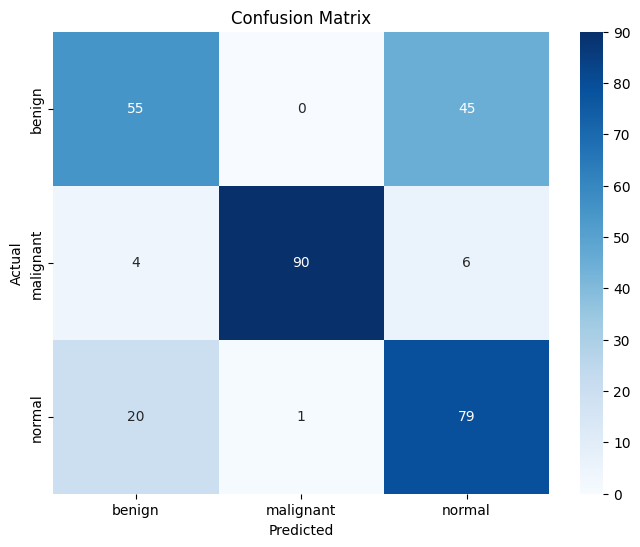

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


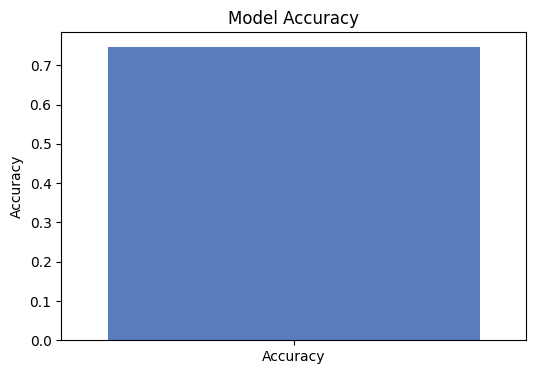

Accuracy: 74.67%
              precision    recall  f1-score   support

      benign       0.70      0.55      0.61       100
   malignant       0.99      0.90      0.94       100
      normal       0.61      0.79      0.69       100

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300

Accuracy: 0.7466666666666667
10/10 [==============================] - 1s 141ms/step


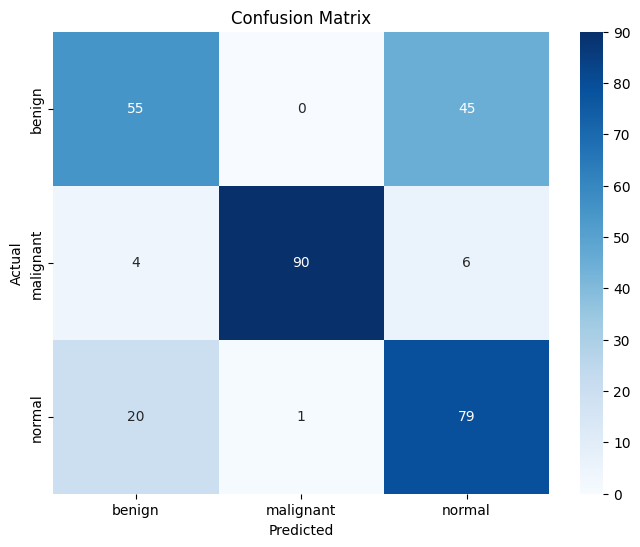

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


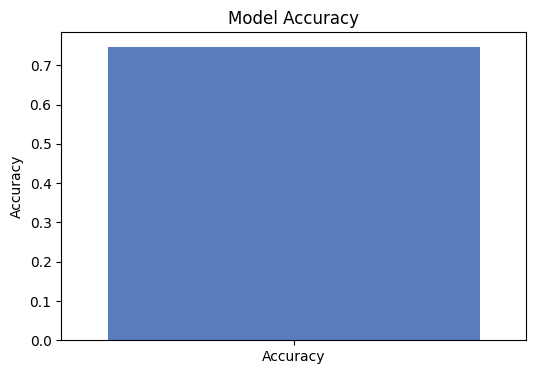

Accuracy: 74.67%
              precision    recall  f1-score   support

      benign       0.70      0.55      0.61       100
   malignant       0.99      0.90      0.94       100
      normal       0.61      0.79      0.69       100

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300

Accuracy: 0.7466666666666667


In [ ]:
# Evaluate on clean test data
evaluate_ensemble_with_generator(clean_test_generator, loaded_models, class_names)

# Evaluate on noisy test data
evaluate_ensemble_with_generator(noise_test_generator, loaded_models, class_names)



In [ ]:
def visualize_predictions(generator, model_list, class_names, num_images=10):
    # Generate a batch of images and labels from the generator
    generator.reset()  # Reset the generator
    images, labels = next(generator)

    # Predict with the ensemble
    preds = ensemble_predictions_for_generator(model_list, generator)
    predicted_classes = np.argmax(preds, axis=1)[:num_images]

    true_labels = np.argmax(labels, axis=1)[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].astype('uint8'))
        ax.axis('off')
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_classes[i]]}")



10/10 [==============================] - 1s 144ms/step


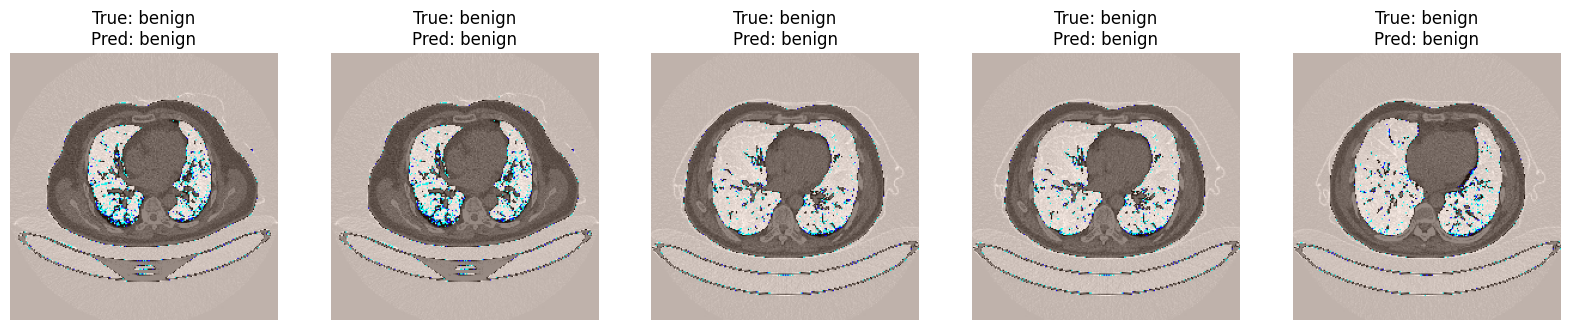

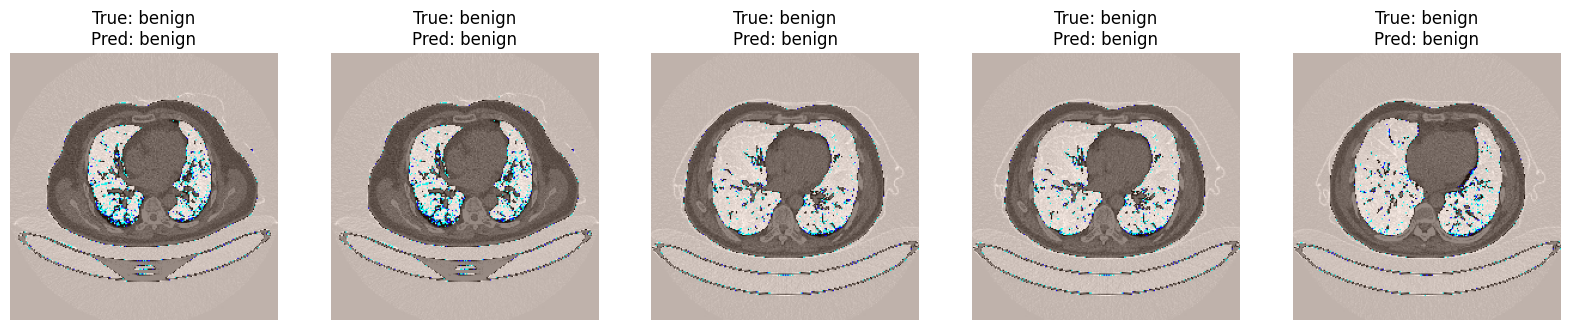

In [ ]:
# Visualize predictions for clean test data
visualize_predictions(clean_test_generator, loaded_models, class_names, num_images=5)

# Visualize predictions for noisy test data
visualize_predictions(noise_test_generator, loaded_models, class_names, num_images=5)
